In [104]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from matplotlib.pyplot import figure

The rssi & distance data generated with the Herald-Flutter2.0 app can get from Android and iPhones as follows:
* Android. Use adb with the following path:
  ```> adb pull /storage/emulated/0/Android/data/com.example.herald_flutter/files```
* iOS: Use the Devices and Simulators option in XCode (Windows|Devices and Simulator) to download the app's container, and then explore the container's contents to locate the data file:
  - ![Devices and Simulators](./1-devices-and-simulators.png)
  - ![Container's contents](./2-Show-container-contents.png)
  - ![Data file](./3-data-file-location.png)

In [109]:
# Simple 1-D Kalman Filter based on the code available at:
# https://github.com/denyssene/SimpleKalmanFilter
class SimpleKalmanFilter:
    def __init__(self, err_measure, err_est, p_noise):
        self.err_measure = err_measure
        self.err_estimate = err_est
        self.q = p_noise
        self.current_estimate = 0
        self.last_estimate = 0
        self.kalman_gain = 0
        
    def updateEstimate(self, measure):
        self.kalman_gain = self.err_estimate / (self.err_estimate + self.err_measure)
        self.current_estimate = self.last_estimate + self.kalman_gain * (measure - self.last_estimate)
        self.err_estimate = (1.0 - self.kalman_gain) * self.err_estimate + abs(self.last_estimate - self.current_estimate) * self.q
        self.last_estimate = self.current_estimate
        return self.current_estimate

    def setMeasurementError(self, err_measure):
        self.err_measure = err_measure
        
    def setEstimateError(self, err_est):
        self.err_estimate = err_est
        
    def setProcessNoise(self, p_noise):
        self.q = p_noise

    def getKalmanGain(self):
        return self.kalman_gain
    
    def getEstimateError(self):
        return self.err_estimate

In [110]:
df_iphone = pd.read_csv("rssi-distance-iphone.csv")
df_iphone.reset_index(inplace=True)
df_iphone

,index,id,phone,rssi_raw,rssi_median,distance
0,0,509757740,1,-81.0,-82.5,0.5
1,1,509757740,1,-80.0,-82.0,0.5
2,2,509757740,1,-84.0,-82.5,0.5
3,3,509757740,1,-81.0,-82.0,1.5
4,4,509757740,1,-80.0,-81.5,1.5
...,...,...,...,...,...,...
586,586,509757740,1,-97.0,-93.5,0.5
587,587,509757740,1,-97.0,-94.0,0.5
588,588,509757740,1,-94.0,-94.0,0.5
589,589,509757740,1,-89.0,-94.0,0.5


In [113]:
# The 0.01 parameter seems good for RSSI data, smaller results in too much smoothing, larger in too much noise
kfilter = SimpleKalmanFilter(1, 1, 0.01)
kalman = lambda row, colname: kfilter.updateEstimate(row[colname])

In [114]:
kval_iphone = df_iphone.apply(kalman, colname='rssi_raw', axis=1)
df_iphone = df_iphone.assign(rssi_kalman=kval_iphone.values)

<AxesSubplot:xlabel='index', ylabel='rssi_raw'>

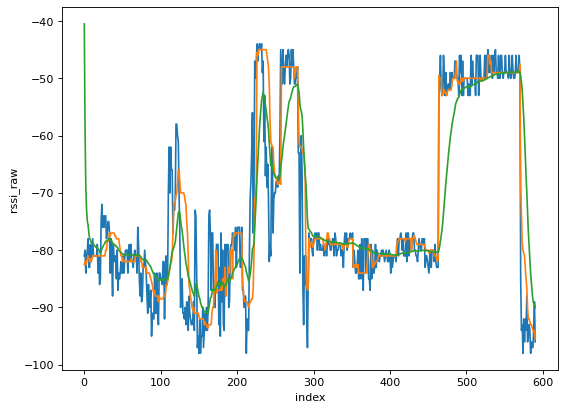

In [125]:
figure(figsize=(8, 6), dpi=80)

sns.lineplot(x='index', y='rssi_raw', data=df_iphone)
sns.lineplot(x='index', y='rssi_median', data=df_iphone)
sns.lineplot(x='index', y='rssi_kalman', data=df_iphone)

<AxesSubplot:ylabel='distance'>

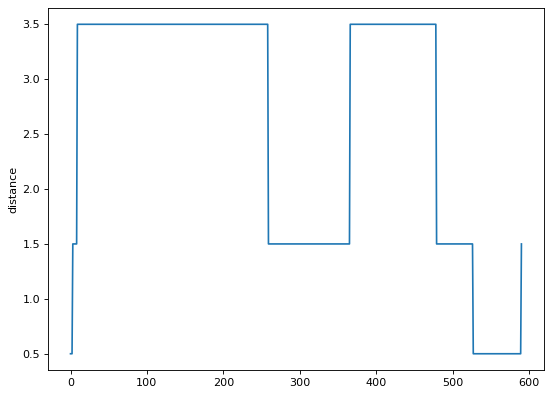

In [116]:
figure(figsize=(8, 6), dpi=80)
sns.lineplot(x='index', y='distance', data=df_iphone)

In [99]:
df_android = pd.read_csv("rssi-distance-android.csv")
df_android.reset_index(inplace=True)
df_android

,index,id,phone,rssi_raw,rssi_median,distance
0,0,327649634,0,-54.0,-53.0,0.5
1,1,327649634,0,-54.0,-53.0,0.5
2,2,327649634,0,-53.0,-53.0,0.5
3,3,327649634,0,-52.0,-53.0,0.5
4,4,327649634,0,-52.0,-53.0,0.5
...,...,...,...,...,...,...
1584,1584,327649634,0,-65.0,-61.0,1.5
1585,1585,327649634,0,-67.0,-61.0,1.5
1586,1586,327649634,0,-68.0,-61.0,1.5
1587,1587,327649634,0,-65.0,-61.5,1.5


In [117]:
kval_android = df_android.apply(kalman, colname='rssi_raw', axis=1)
df_android = df_android.assign(rssi_kalman=kval_android.values)

<AxesSubplot:xlabel='index', ylabel='rssi_raw'>

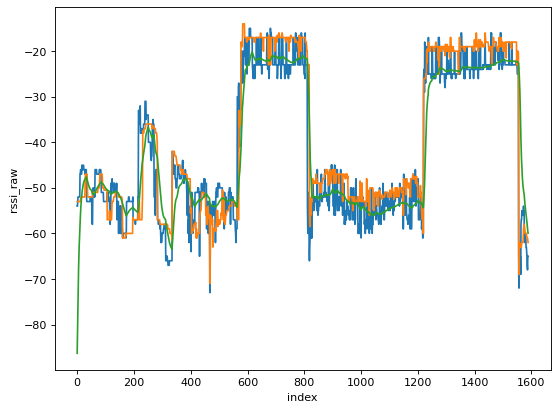

In [122]:
figure(figsize=(8, 6), dpi=80)

sns.lineplot(x='index', y='rssi_raw', data=df_android)
sns.lineplot(x='index', y='rssi_median', data=df_android)
sns.lineplot(x='index', y='rssi_kalman', data=df_android)

<AxesSubplot:ylabel='distance'>

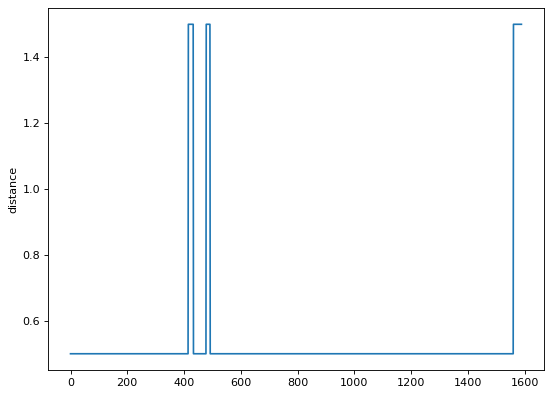

In [103]:
figure(figsize=(8, 6), dpi=80)
sns.lineplot(x='index', y='distance', data=df_android)